#Downstream Analysis of ESM1v and ESM1b predictions

By Rucha

In [ ]:
#imports

import pandas as pd
import pandas as pd
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [ ]:
#Upload the necessary files:

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Read the datasets and merge scores esm1b, esm1v and esm1v on full protein sequence in one dataframe

In [ ]:
#Read the datasets.
df_mut1vfl = pd.read_csv('/content/gdrive/MyDrive/Datasets/esm1v_scores_outputfl.csv')
df_mutesm1b = pd.read_csv('/content/gdrive/MyDrive/Datasets/esm1b_scores_output.csv')
df_mutesm1v = pd.read_csv('/content/gdrive/MyDrive/Datasets/esm1v_scores_output.csv')

#for df_mutesm1v, remove the unwanted substring from the mut_name.
df_mutesm1v['mut_name'] = df_mutesm1v['mut_name'].str.replace(r'\+A2', '', regex=True)
df_mutesm1b['mut_name'] = df_mutesm1b['mut_name'].str.replace(r'\+A2', '', regex=True)

#Rename the esm_score columns
df_mutesm1v = df_mutesm1v.rename(columns={'esm_score': 'esm1v_score'})
df_mut1vfl = df_mut1vfl.rename(columns={'esm_score': 'esm1vfl_score'})
df_mutesm1b = df_mutesm1b.rename(columns={'esm_score': 'esm1b_score'})


#Merge the esm1v and esm1b datasets
df_merged = pd.merge(df_mutesm1v[['seq_id', 'mut_name', 'pos', 'esm1v_score']], df_mutesm1b[['seq_id', 'mut_name', 'pos', 'esm1b_score']],
                     on=['seq_id', 'mut_name', 'pos'], how='outer')

#merge the result with the esm1vfl dataset
df_merged = pd.merge(df_merged, df_mut1vfl[['seq_id', 'mut_name', 'pos', 'esm1vfl_score']],
                     on=['seq_id', 'mut_name', 'pos'], how='outer')

#print(df_merged.head())

Load the Human Domainome dataset to extract the experimental growthrates and merge with our dataframe which has ESM1v and ESM1b scores. Basically, prepare the dataset for correlation analysis

In [ ]:
df_variant = pd.read_csv('/content/gdrive/MyDrive/Datasets/mutated_domainome_merged_filtered.txt', sep = '\t')
df_variant.head()

,wt_seq,aa_seq,dom_ID,variant_ID,pos,pos_in_uniprot,WT,wt_aa,mut_aa,nt_seq,...,PFAM_ID,wt_gr,delta_gr,dead_gr,scaled_gr,scaled_gr_sigma,dom_ID_lib,proline,core,mut_class
0,ACEQCGKSFARKDMLKEHMRVH,*CEQCGKSFARKDMLKEHMRVH,P57071_PF00096_1085,P57071_PF00096_1085_A1*,1.0,1085.0,False,A,*,NaN,...,PF00096,0.098028,-0.104256,0.025905,-1.445534,0.317667,P57071_PF00096_1085_A1,False,surface,NaN
1,ACEQCGKSFARKDMLKEHMRVH,A*EQCGKSFARKDMLKEHMRVH,P57071_PF00096_1085,P57071_PF00096_1085_C2*,2.0,1086.0,False,C,*,NaN,...,PF00096,0.098028,-0.069372,0.025905,-0.961864,0.410906,P57071_PF00096_1085_A1,False,core,NaN
2,ACEQCGKSFARKDMLKEHMRVH,AAEQCGKSFARKDMLKEHMRVH,P57071_PF00096_1085,P57071_PF00096_1085_C2A,2.0,1086.0,False,C,A,NaN,...,PF00096,0.098028,-0.022340,0.025905,-0.309755,0.096451,P57071_PF00096_1085_A1,False,core,hydrophobic
3,ACEQCGKSFARKDMLKEHMRVH,AC*QCGKSFARKDMLKEHMRVH,P57071_PF00096_1085,P57071_PF00096_1085_E3*,3.0,1087.0,False,E,*,NaN,...,PF00096,0.098028,-0.100010,0.025905,-1.386659,0.243252,P57071_PF00096_1085_A1,False,surface,NaN
4,ACEQCGKSFARKDMLKEHMRVH,ACAQCGKSFARKDMLKEHMRVH,P57071_PF00096_1085,P57071_PF00096_1085_E3A,3.0,1087.0,False,E,A,NaN,...,PF00096,0.098028,-0.028431,0.025905,-0.394199,0.110932,P57071_PF00096_1085_A1,False,surface,hydrophobic


In [ ]:
#df_variant.columns.to_list()

In [ ]:
# Merge the two datasets to extract the corresponding growth rate for correlation
df_merged = df_merged.merge(df_variant[['variant_ID', 'growthrate', 'scaled_gr']],
  left_on='mut_name', right_on='variant_ID', how='left')

df_merged = df_merged.drop(columns='variant_ID')

Calculate the per doamin Spearman correlation

In [ ]:
#extract domain ID
df_merged['domain_id'] = df_merged['mut_name'].apply(lambda x: "_".join(x.split("_")[:-1]))

#filter
df_valid = df_merged.dropna(subset=['esm1v_score', 'esm1b_score', 'growthrate'])

# Compute per domain Spearman correlation
domain_corrs = []
for domain, group in df_valid.groupby('domain_id'):
  if len(group) >= 5:
    corr_v, _ = spearmanr(group['esm1v_score'], group['growthrate'])
    corr_b, _ = spearmanr(group['esm1b_score'], group['growthrate'])
    domain_corrs.append({'domain_id': domain,'spearman_esm1v': corr_v,'spearman_esm1b': corr_b})

corr_df = pd.DataFrame(domain_corrs)
#corr_df.head()

SCOP CLASS list extracted from PFAM Database. Annotate each PFAM_ID with its corresponding SCOP CLASS

In [ ]:
#extract PFAM ID and merge SCOP class info
corr_df['PFAM_ID'] = corr_df['domain_id'].apply(lambda x: x.split('_')[1])
scop_map = pd.read_csv('/content/gdrive/MyDrive/Datasets/PFAM_ID_to_SCOP_class.tsv', sep='\t')
corr_df = corr_df.merge(scop_map, on='PFAM_ID', how='left')

#keep SCOP classes with only ≥2 domains
valid_classes = corr_df['scop_class'].value_counts()[lambda x: x >= 2].index
filtered_df = corr_df[corr_df['scop_class'].isin(valid_classes)]

In [ ]:
# For violin plot
df_long = filtered_df.melt(id_vars='scop_class', value_vars=['spearman_esm1v', 'spearman_esm1b'],
                           var_name='Model', value_name='Spearman Correlation')

df_long['Model'] = df_long['Model'].replace({'spearman_esm1v': 'ESM-1v','spearman_esm1b': 'ESM-1b'})

# For point plot
df_bar = filtered_df.melt(id_vars='scop_class', value_vars=['spearman_esm1v', 'spearman_esm1b'], var_name='Model',
                          value_name='Spearman Correlation')

df_bar['Model'] = df_bar['Model'].replace({'spearman_esm1v': 'ESM-1v','spearman_esm1b': 'ESM-1b'})

PLOT

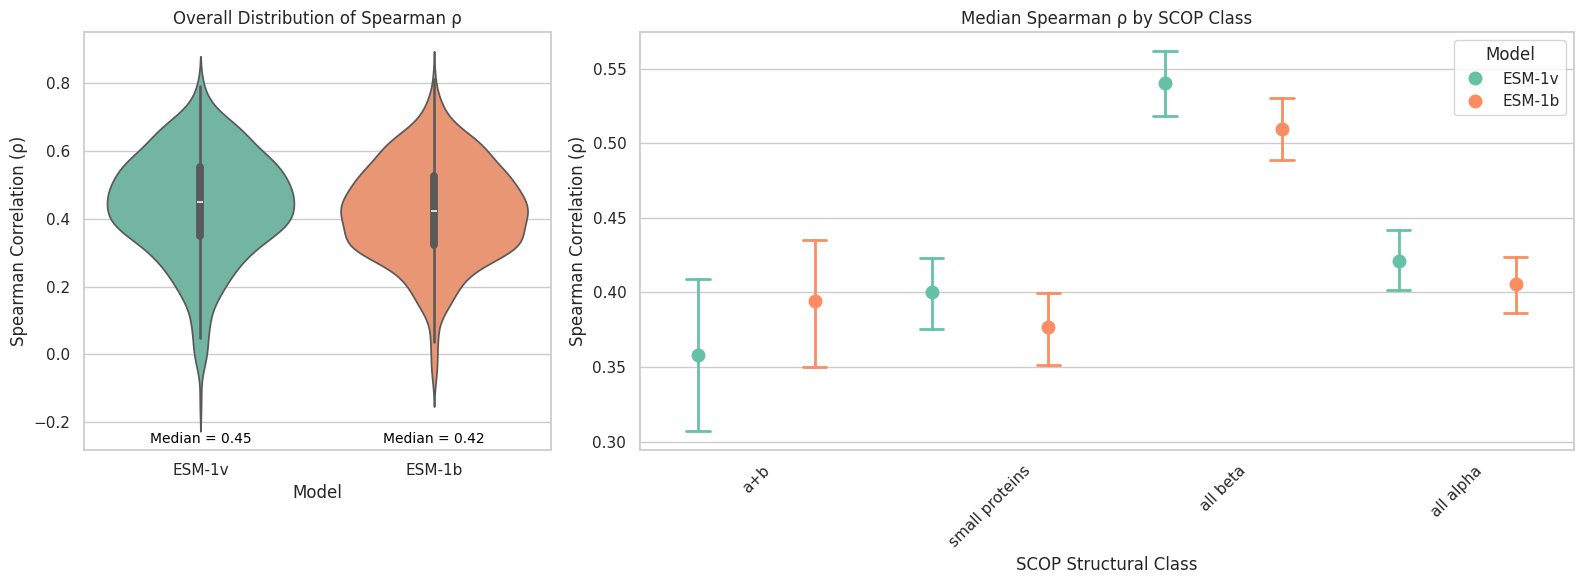

In [ ]:
sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 2]})

#Overall violin plot
sns.violinplot(data=df_long, x='Model', y='Spearman Correlation', hue='Model', legend=False, inner='box', ax=axes[0], palette='Set2')
axes[0].set_title("Overall Distribution of Spearman ρ")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Spearman Correlation (ρ)")

#Annotate median value
medians = df_long.groupby('Model')["Spearman Correlation"].median()
for i, model in enumerate(['ESM-1v', 'ESM-1b']):
  axes[0].text(i, -0.25, f"Median = {medians[model]:.2f}", ha='center', va='center', fontsize=10, color='black')

#Point plot
sns.pointplot(data=df_bar, x='scop_class', y='Spearman Correlation', hue='Model', ax=axes[1], dodge=0.5, linestyle='none', errorbar=('ci', 95), capsize=0.1, markersize=8,
              err_kws={'linewidth': 2}, palette='Set2')

axes[1].set_title("Median Spearman ρ by SCOP Class")
axes[1].set_xlabel("SCOP Structural Class")
axes[1].set_ylabel("Spearman Correlation (ρ)")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Model')

plt.tight_layout()
plt.savefig("spearman_correlation_by_model_and_class.pdf", bbox_inches='tight')
plt.show()

Scatter Plot

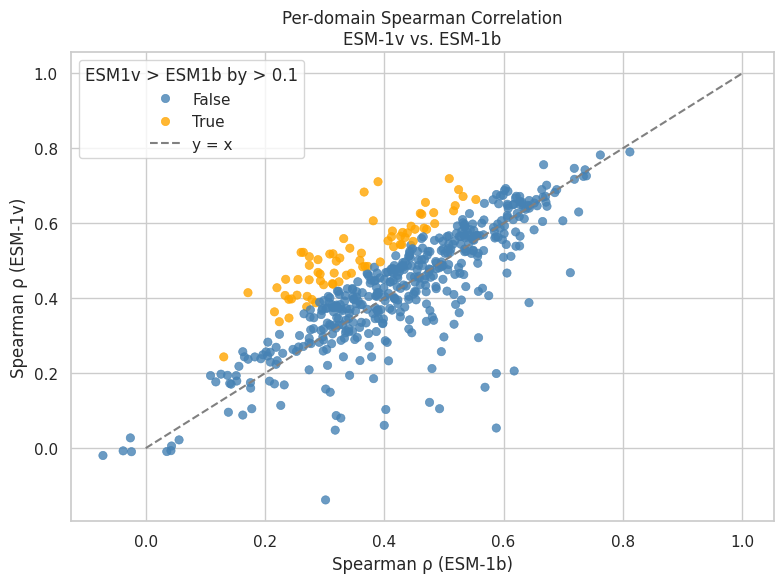

In [ ]:

corr_df = corr_df.dropna(subset=["spearman_esm1v", "spearman_esm1b"])

corr_df["highlight"] = (corr_df["spearman_esm1v"] - corr_df["spearman_esm1b"]) > 0.1

#Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=corr_df, x="spearman_esm1b", y="spearman_esm1v", hue="highlight", palette={True: "orange", False: "steelblue"},
                edgecolor=None, alpha=0.8)


plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='y = x')

#labels
plt.xlabel("Spearman ρ (ESM-1b)")
plt.ylabel("Spearman ρ (ESM-1v)")
plt.title("Per-domain Spearman Correlation\nESM-1v vs. ESM-1b")
plt.legend(title="ESM1v > ESM1b by > 0.1")
plt.grid(True)
plt.tight_layout()
plt.savefig("spearman_correlation_per_domain.pdf", bbox_inches='tight')
plt.show()

In [ ]:
corr_df['delta_corr'] = corr_df['spearman_esm1v'] - corr_df['spearman_esm1b']

top_domains = corr_df[corr_df['delta_corr'] > 0.1].sort_values(by='delta_corr', ascending=False)

top_domains[['domain_id', 'spearman_esm1v', 'spearman_esm1b', 'delta_corr', 'scop_class']].head(10)

,domain_id,spearman_esm1v,spearman_esm1b,delta_corr,scop_class
60,O75970_PF00595_1003,0.711078,0.389541,0.321536,all beta
336,Q7Z6G8_PF00536_812,0.683531,0.366244,0.317287,all alpha
76,O95475_PF00046_134,0.522470,0.260476,0.261994,all alpha
74,O95343_PF00046_212,0.522676,0.264355,0.258321,all alpha
512,Q9Y4J8_PF00569_235,0.414944,0.171441,0.243503,small proteins
518,Q9Y6V0_PF05715_1058,0.511082,0.274374,0.236707,small proteins
301,Q15911_PF00046_2147,0.559297,0.332007,0.227290,all alpha
332,Q7Z3T8_PF01363_744,0.606757,0.381534,0.225223,small proteins
425,Q9BTC0_PF00628_263,0.450596,0.234688,0.215908,small proteins
145,P20264_PF00046_408,0.503119,0.288849,0.214271,all alpha


Scatter density plot comparing ESM1v mutation scores derived from domain only sequences (esm1v_score) and full-length protein sequences (esm1vfl_score).

In [ ]:
valid_mask = ~df_merged["esm1v_score"].isna() & ~df_merged["esm1vfl_score"].isna()
corr_val, corr_p = pearsonr(df_merged.loc[valid_mask, "esm1v_score"],
                            df_merged.loc[valid_mask, "esm1vfl_score"])
print(f"\nCorrelation = {corr_val:.4f} (p={corr_p:.1e})")


Correlation = 0.9029 (p=0.0e+00)


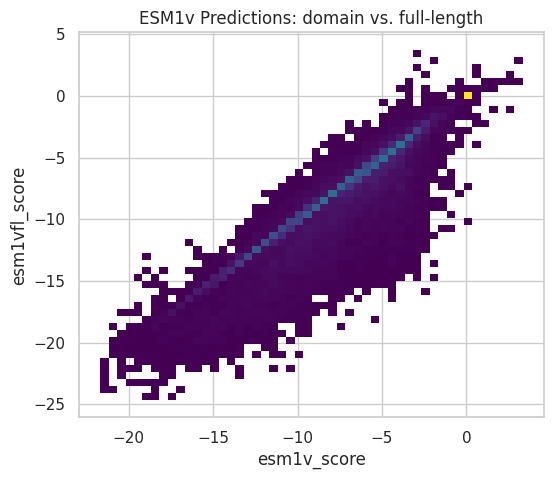

In [ ]:
#plot
plt.figure(figsize=(6,5))
sns.histplot(data=df_merged, x="esm1v_score",
    y="esm1vfl_score", bins=50, pthresh=None,
    cmap="viridis")
plt.title("ESM1v Predictions: domain vs. full-length")
plt.savefig("FullvsDomain.pdf", bbox_inches='tight')
plt.show()